# Visual Searching

# Build Time
## System Components Overview

**Feature Extractor**: **DinoV2**
- **Purpose**: Responsible for extracting detailed feature vectors from images.

**Vector Database and Searching**: **FAISS**
- **Purpose**: Manages storage of feature vectors and performs efficient similarity searches.

### Workflow Diagram

Image -> DinoV2 -> Dump Index to FAISS


This sequence represents the workflow from inputting an image, processing it through DinoV2 to extract features, and then storing and querying these features using FAISS.

In [ ]:
!pip install faiss-cpu

In [ ]:
import os
import faiss
import torch
import numpy as np
import pandas as pd
import gc
from PIL import Image
from torchvision.transforms.functional import to_tensor
from transformers import AutoImageProcessor, Dinov2Model

In [8]:
def load_image(image_path):
    """
    Load a single image from the specified path and convert it into a PyTorch tensor.

    Parameters:
    - image_path (str): Path to the image file.

    Returns:
    - torch.Tensor: Image tensor with pixel values normalized between 0 and 1.
    """
    image = Image.open(image_path).convert('RGB')  # Convert image to RGB
    image = to_tensor(image)  # Transform image to tensor and normalize pixel values
    return image

def extract_features(image_path, model_name='facebook/dinov2-base', device='cuda'):
    """
    Extract features from an image using a specified DINOv2 model.

    Parameters:
    - image_path (str): Path to the image file.
    - model_name (str): Identifier for a pretrained model.
    - device (str): Device type to perform computations ('cuda' or 'cpu').

    Returns:
    - numpy.ndarray: Extracted image features as a 1D array.
    """
    processor = AutoImageProcessor.from_pretrained(model_name)  # Load image processor
    model = Dinov2Model.from_pretrained(model_name)  # Load model
    model.to(device).eval()  # Set model to evaluation mode and move to specified device

    image = load_image(image_path).unsqueeze(0).to(device)  # Load and preprocess image
    with torch.no_grad():  # No need to track gradients for inference
        inputs = processor(images=image, return_tensors="pt", do_rescale=False)  # Prepare model inputs
        inputs = {k: v.to(device) for k, v in inputs.items()}  # Ensure tensors are on the correct device
        outputs = model(**inputs)  # Pass inputs through the model
        image_features = outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()  # Extract and transfer features to CPU

    # Clean up memory after feature extraction
    del image, inputs, outputs
    gc.collect()
    torch.cuda.empty_cache()

    return image_features

def create_faiss_index(features):
    """
    Create a FAISS index for similarity search from a list of feature vectors.

    Parameters:
    - features (List[numpy.ndarray]): List of feature vectors.

    Returns:
    - faiss.IndexFlatL2: Initialized FAISS index.
    """
    features = np.vstack(features)  # Convert list of feature arrays to a single matrix
    dimension = features.shape[1]  # Determine feature dimensionality
    index = faiss.IndexFlatL2(dimension)  # Create an L2 distance-based flat index
    index.add(features)  # Add features to the index
    return index

def save_faiss_index(index, output_path= r"C:/Users/ttsae/OneDrive/Desktop/IntelliShop/mid_sprint2/backend/Combined_Data/faiss_index_combined.bin"):
    """
    Persist a FAISS index to disk at the specified location.

    Parameters:
    - index (faiss.IndexFlatL2): The FAISS index to save.
    - output_path (str): File path where the index will be saved.
    """
    faiss.write_index(index, output_path)  # Save the index to a file

def save_csv(image_paths, index_ids, output_path= r"C:/Users/ttsae/OneDrive/Desktop/IntelliShop/mid_sprint2/backend/Combined_Data/image_index_combined.csv"):
    """
    Save a mapping of image paths to their corresponding index IDs in a CSV file.

    Parameters:
    - image_paths (List[str]): List of image file paths.
    - index_ids (List[int]): Corresponding index IDs.
    - output_path (str): Path to save the CSV file.
    """
    df = pd.DataFrame({
        'image_path': image_paths,
        'index_id': index_ids
    })
    df.to_csv(output_path, index=False)  # Write DataFrame to CSV without an index column

def get_image_paths(root_folder):
    """
    Collect all image file paths recursively from the specified root directory.

    Parameters:
    - root_folder (str): Root directory to search for image files.

    Returns:
    - List[str]: List of full paths to image files.
    """
    image_paths = []
    for subdir, dirs, files in os.walk(root_folder):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                full_path = os.path.join(subdir, file)
                image_paths.append(full_path)
    return image_paths


Input Folder Structure:

All Images                 
├── Outfitter Images       
│     └── images             
└── Llama Images           
      └── images            


In [21]:
folder_path =  r"C:/Users/ttsae/OneDrive/Desktop/IntelliShop/mid_sprint2/backend/All Images"
image_paths = get_image_paths(folder_path)
features = [extract_features(path) for path in image_paths]
index = create_faiss_index(features)
save_faiss_index(index)
save_csv(image_paths, list(range(len(image_paths))))

### Just for checking the FAISS entries against images, unrelated to main

In [22]:
import os
import faiss
import pandas as pd

def load_faiss_index(index_path):
    """
    Load the FAISS index from the specified file.
    """
    return faiss.read_index(index_path)

def load_csv(csv_path):
    """
    Load the CSV file containing image names and their corresponding index ids.
    """
    outfitters_data = pd.read_csv(csv_path)
    return outfitters_data

def compare_entries(index, df):
    """
    Compare the number of entries in the FAISS index and the dataframe from the CSV.
    """
    index_count = index.ntotal  # Get the number of vectors in the FAISS index
    csv_count = df.shape[0]  # Get the number of rows in the dataframe
    print(f"FAISS Index count: {index_count}")
    print(f"CSV file count: {csv_count}")
    return index_count == csv_count

# Example usage:
index_path = r"C:/Users/ttsae/OneDrive/Desktop/IntelliShop/mid_sprint2/backend/Combined_Data/faiss_index_combined.bin"  # Adjust path to your FAISS index
csv_path = r"C:/Users/ttsae/OneDrive/Desktop/IntelliShop/mid_sprint2/backend/Combined_Data/image_index_combined.csv"  # Adjust path to your CSV file

index = load_faiss_index(index_path)
csv_df = load_csv(csv_path)
if compare_entries(index, csv_df):
    print("Both the FAISS index and CSV file have the same number of entries.")
else:
    print("Mismatch in the number of entries between the FAISS index and CSV file.")


FAISS Index count: 1108
CSV file count: 1108
Both the FAISS index and CSV file have the same number of entries.


# RUN TIME

## Searching Images

- **Capture Image**: Start the process by capturing an image.
- **Object Detection**: Use **YOLOv8 Finetuned**, accessed via the **Roboflow API**, for detecting objects within the image.
- **Feature Extractor**: Employ **DinoV2** to extract feature vectors from the detected objects.
- **Searching**: Utilize **FAISS** for fast and efficient searching of similar features within the vector database.

### Workflow Diagram

Image -> YOLO -> DinoV2 -> FAISS


This workflow diagram represents the sequence of steps from capturing an image, performing object detection with YOLOv8, extracting features using DinoV2, and finally searching for similar images using FAISS.


In [ ]:
!pip install roboflow opencv-python matplotlib faiss-gpu roboflow ultralytics

In [23]:
import torch
from PIL import Image
import numpy as np
import pandas as pd
import faiss
from IPython.display import display
from transformers import AutoImageProcessor, Dinov2Model
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
from roboflow import Roboflow
import requests

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 881.3/881.3 kB 49.5 MB/s eta 0:00:00


# **Searching**

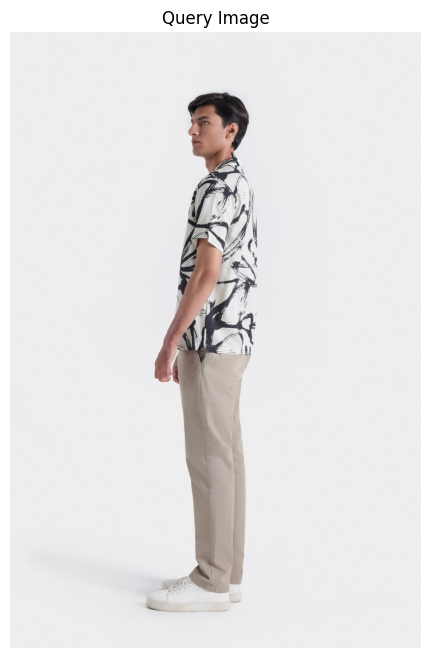

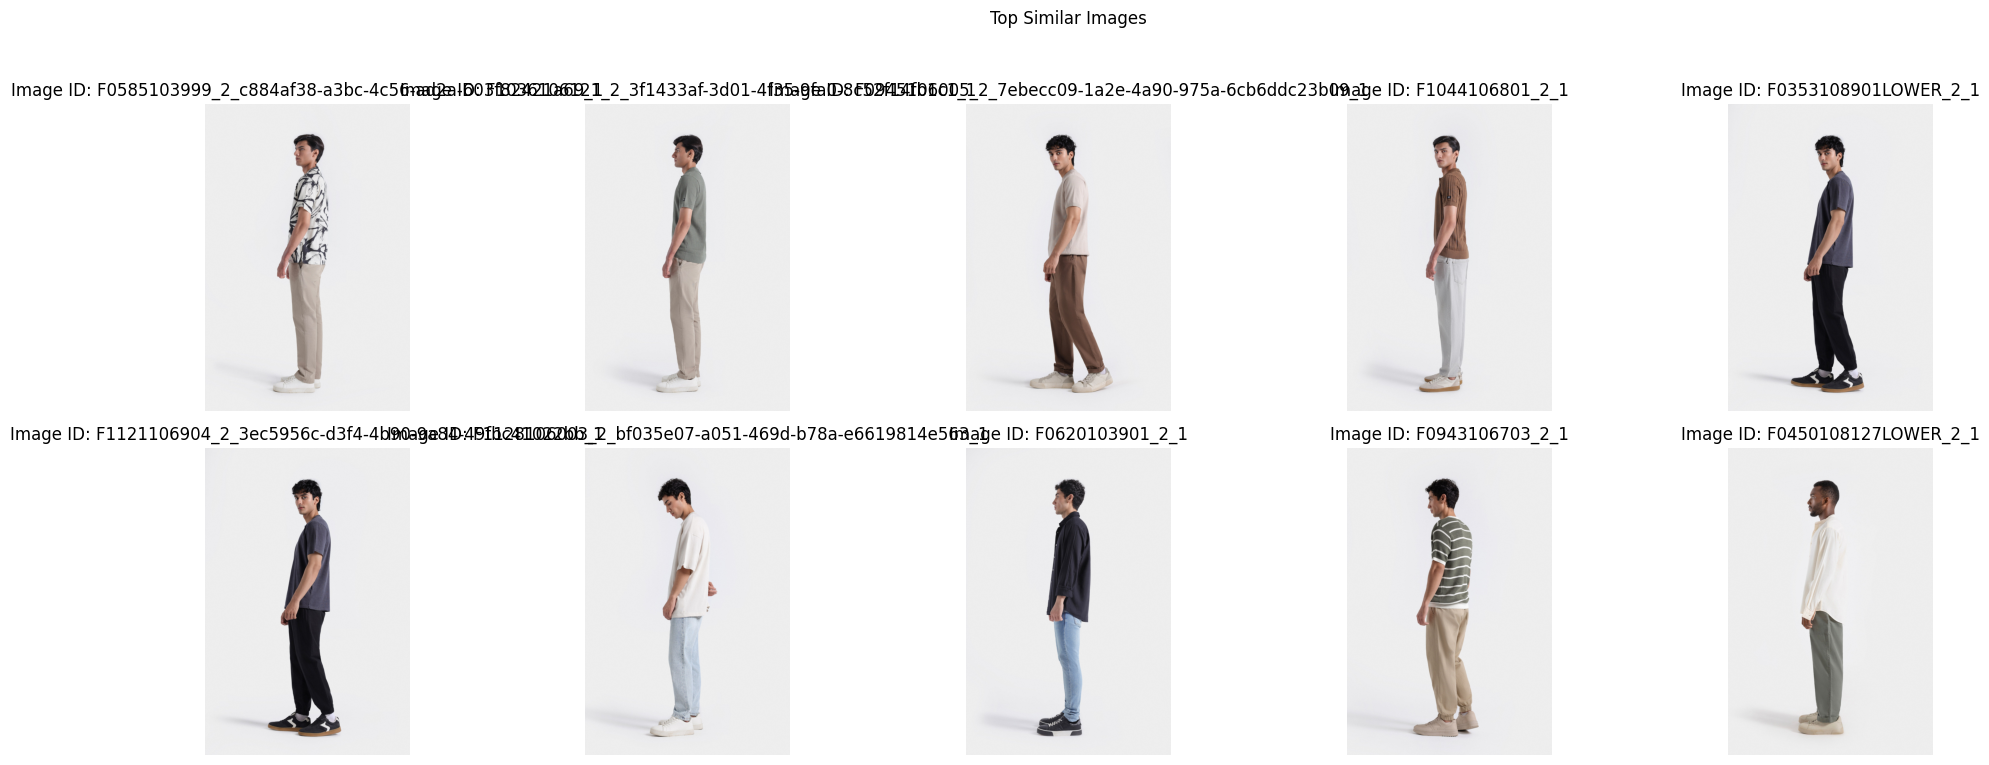

In [ ]:
display_similar_images(r"C:/Users/ttsae/OneDrive/Desktop/IntelliShop/mid_sprint2/backend/All Images/Outfitters_Images/F0585103999_2_c884af38-a3bc-4c56-ad2a-603f82421a69_1.jpg")

loading Roboflow workspace...
loading Roboflow project...
Loading FAISS index and CSV data...
FAISS and CSV loaded successfully.
Models loaded successfully.
Performing object detection...
0: Class: short-sleeve, Confidence: 0.87, Box: 244, 719, 1426, 1439
Enter the index of the detection to process: 0


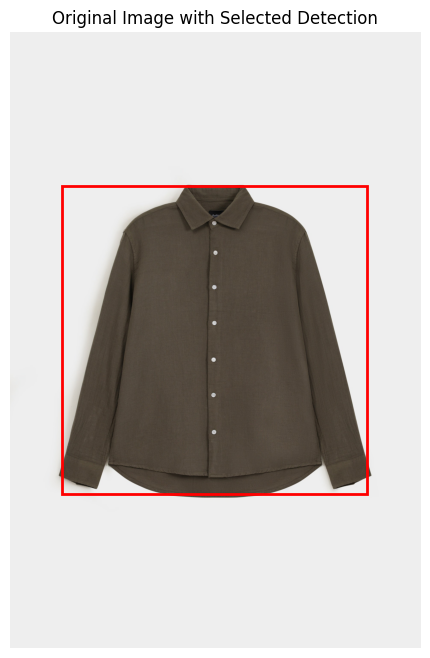

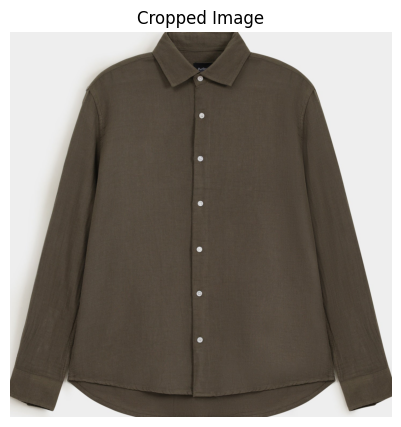

Extracting features using DINO model...
Features extracted successfully.
Querying FAISS index...
Query completed. Retrieving results from DataFrame...
0: https://lamaretail.com/cdn/shop/files/MAS24TP054-OLIVE-INTERLOCK-TEE_11.jpg?v=1717478095&width=1000 with distance 140.84
1: https://outfitters.com.pk/cdn/shop/files/F0573103120_3.jpg with distance 149.15
2: https://lamaretail.com/cdn/shop/files/MAS24TP022-NAVY-BAND-COLLAR-SHIRT_3.jpg?v=1715833930&width=1080 with distance 155.76
3: https://lamaretail.com/cdn/shop/files/UDCMWT0006-CAMEL_2.jpg?v=1707991252&width=1000 with distance 156.02
4: https://lamaretail.com/cdn/shop/files/SHFMWS0031-RUST-HIGH-TOP-LEATHER-LOAFERS_9.jpg?v=1711084179&width=1000 with distance 156.21
5: https://outfitters.com.pk/cdn/shop/files/F0620103901_6.jpg with distance 161.21
6: https://outfitters.com.pk/cdn/shop/files/F0573103901_11.jpg with distance 175.28
7: https://lamaretail.com/cdn/shop/files/UDCMWT0005-BEIGE-BASIC-SHIRT_3.jpg?v=1697729204&width=1000 with di

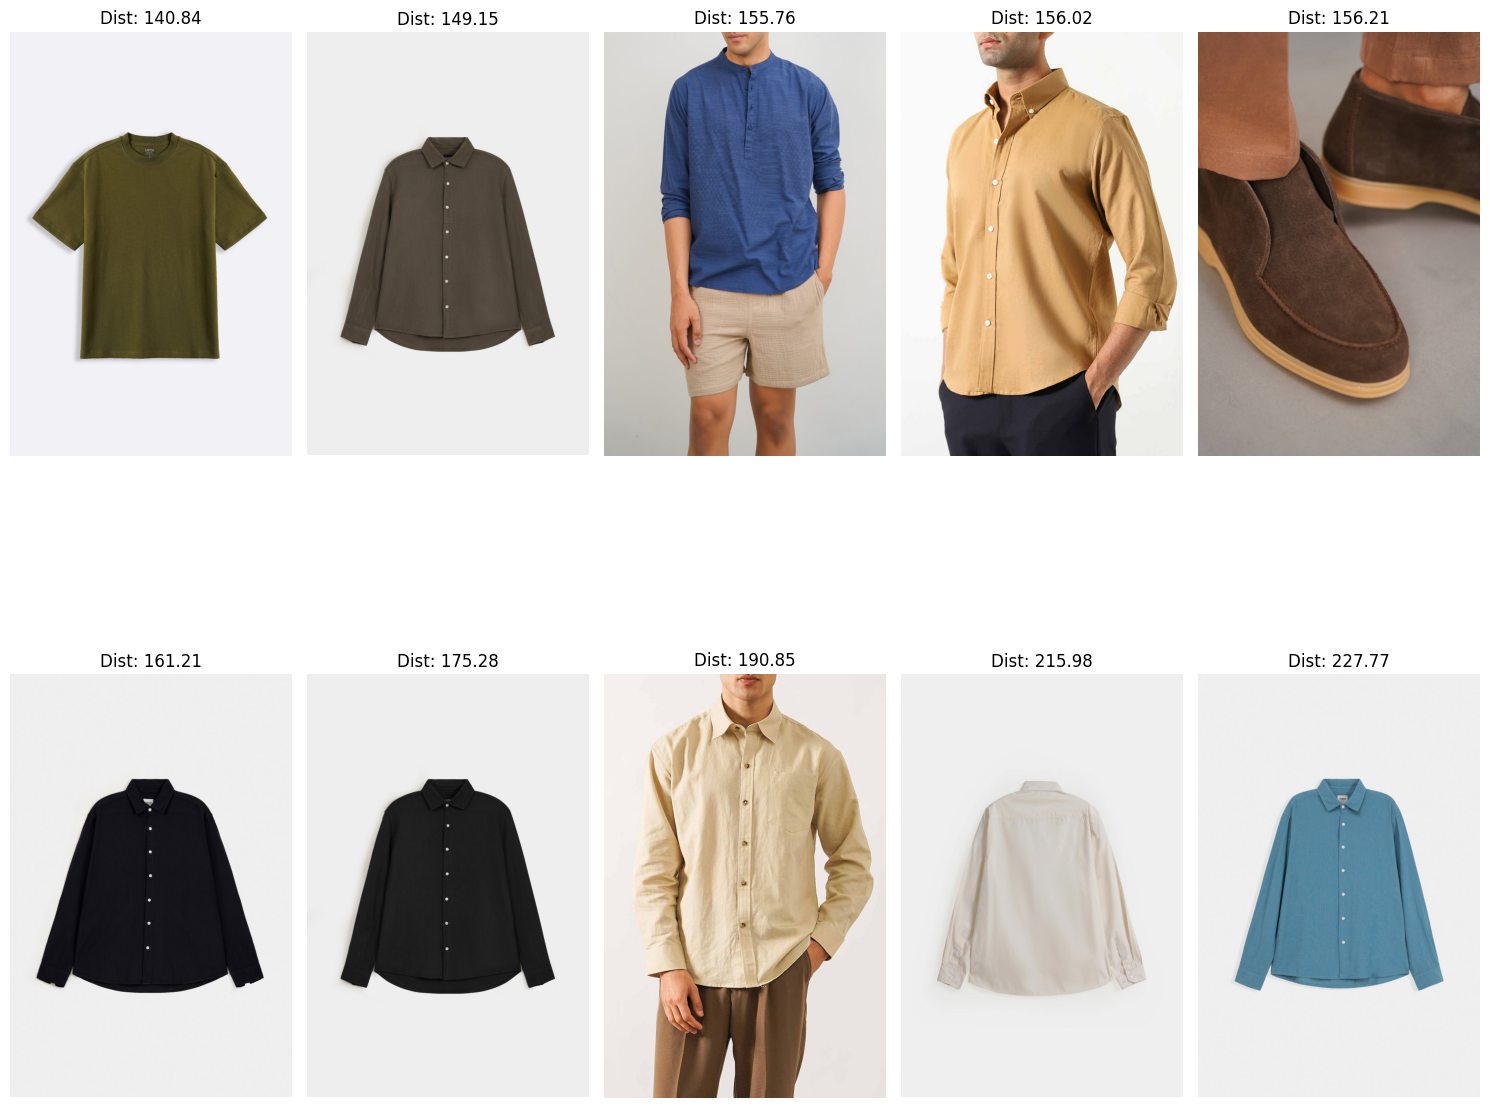

In [43]:


# Initialize Roboflow API and load a specific project and model version
rf = Roboflow(api_key="fzoL6Dj2WntmtiY0gyrF")
project_clothes = rf.workspace().project("clothes-dataset-e9wyj")
model_clothes = project_clothes.version(2).model

# Define paths to the FAISS index and CSV file containing image data
index_path = r"C:/Users/ttsae/OneDrive/Desktop/IntelliShop/mid_sprint2/backend/Combined_Data/faiss_index_combined.bin"  # Adjust path to your FAISS index
csv_path = r"C:/Users/ttsae/OneDrive/Desktop/IntelliShop/mid_sprint2/backend/Combined_Data/image_index_combined.csv"  # Adjust path to your CSV file

# Load the FAISS index and CSV file, and initialize DINO models
print("Loading FAISS index and CSV data...")
index = faiss.read_index(index_path)
df = pd.read_csv(csv_path)
print("FAISS and CSV loaded successfully.")

processor_dino = AutoImageProcessor.from_pretrained("facebook/dinov2-base")
model_dino = Dinov2Model.from_pretrained("facebook/dinov2-base").to('cuda')
print("Models loaded successfully.")

def dinoFeatureExtractor(cropped_image):
    """ Extract features from a cropped image using the DINO model.

    Parameters:
    - cropped_image (PIL.Image): The cropped region of an image.

    Returns:
    - torch.Tensor: Extracted image features.
    """
    print("Extracting features using DINO model...")
    processed_image = Image.fromarray(cropped_image)
    query_inputs = processor_dino(images=[processed_image], return_tensors="pt")
    query_inputs = {k: v.to('cuda') for k, v in query_inputs.items()}
    with torch.no_grad():
        query_image_features = model_dino(**query_inputs)
        image_features = query_image_features.last_hidden_state.mean(dim=1)
    print("Features extracted successfully.")
    return image_features.cpu().numpy()

def query_faiss(image_features, k=10):
    """ Query the FAISS index with the extracted image features to find similar images.

    Parameters:
    - image_features (numpy.array): The features of the image to query.
    - k (int): The number of similar images to retrieve.

    Returns:
    - list: Data about the similar images including URL and distance.
    """
    print("Querying FAISS index...")
    query_features = image_features.squeeze()
    distances, indices = index.search(np.expand_dims(query_features, axis=0), k)
    print("Query completed. Retrieving results from DataFrame...")
    images_data = []
    for i, (distance, idx) in enumerate(zip(distances[0], indices[0])):
        print(f"{i}: {df.iloc[idx]['Downloaded Image URL']} with distance {distance:.2f}")
        images_data.append({'url': df.iloc[idx]['Downloaded Image URL'], 'distance': distance})
    return images_data

def display_image_grid(images_data, ncols=5):
    """ Display a grid of images with distances from the FAISS query result.

    Parameters:
    - images_data (list): List of dictionaries with image URL and distance.
    - ncols (int): Number of columns in the grid.
    """
    fig, ax = plt.subplots(nrows=int(np.ceil(len(images_data) / ncols)), ncols=ncols, figsize=(15, 15))
    ax = ax.flatten()
    for i, img_data in enumerate(images_data):
        img = Image.open(requests.get(img_data['url'], stream=True).raw)
        ax[i].imshow(img)
        ax[i].axis('off')
        ax[i].set_title(f"Dist: {img_data['distance']:.2f}")
    plt.tight_layout()
    plt.show()

def process_image(image_path):
    """ Load an image, perform object detection, extract features, query FAISS, and display results.

    Parameters:
    - image_path (str): Path to the image file.
    """
    print("Performing object detection...")
    prediction_clothes = model_clothes.predict(image_path, confidence=40, overlap=30).json()

    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    detections = []
    for i, item in enumerate(prediction_clothes['predictions']):
        x, y, w, h = item['x'], item['y'], item['width'], item['height']
        start_point = (int(x - w/2), int(y - h/2))
        detections.append({'bbox': (start_point[0], start_point[1], w, h), 'class': item['class'], 'confidence': item['confidence']})
        print(f"{i}: Class: {item['class']}, Confidence: {item['confidence']:.2f}, Box: {start_point[0]}, {start_point[1]}, {w}, {h}")

    index = int(input("Enter the index of the detection to process: "))
    selected_detection = detections[index]
    x, y, w, h = selected_detection['bbox']

    # Display the original image with the selected bounding box
    plt.figure(figsize=(8, 8))
    plt.imshow(image_rgb)
    rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
    plt.gca().add_patch(rect)
    plt.title("Original Image with Selected Detection")
    plt.axis('off')
    plt.show()

    # Display the cropped part of the image
    cropped_image = image_rgb[y:y+h, x:x+w]
    plt.figure(figsize=(5, 5))
    plt.imshow(cropped_image)
    plt.title("Cropped Image")
    plt.axis('off')
    plt.show()

    image_features = dinoFeatureExtractor(cropped_image)
    results = query_faiss(image_features)
    display_image_grid(results)

test_image_path = r"C:/Users/ttsae/OneDrive/Desktop/IntelliShop/mid_sprint2/backend/All Images/Outfitters_Images/F0573103120_3_1.jpg"
# Run the processing function
process_image(test_image_path)
